In [35]:
%matplotlib notebook
import scipy as sp
import numpy as np
from scipy.optimize import curve_fit
from scipy import linalg
from pyquaternion import Quaternion
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import cylinder_fitting
from cylinder_fitting.geometry import rotation_matrix_from_axis_and_angle 
from cylinder_fitting import fitting
from trackml.dataset import load_event, load_dataset

In [4]:
hits, cells, particles, truth = load_event("data/sample/train/event000001000")

Plot layers of the detector. There are 10 of them. `z` should be limited to smaller space to get rid of vertical detectors.

<IPython.core.display.Javascript object>


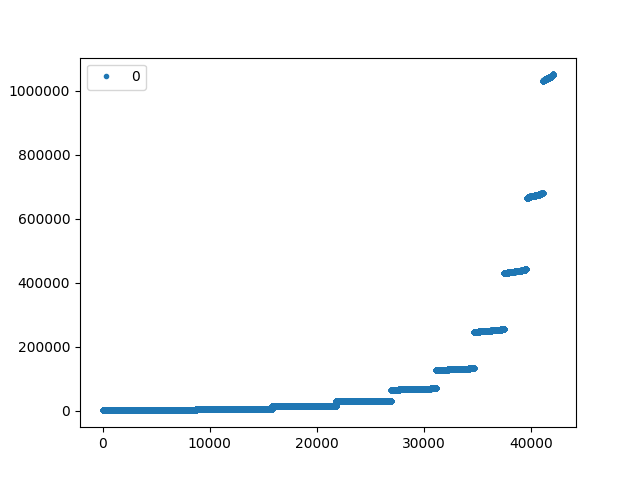

In [19]:
tmp = truth[truth.particle_id != 0]
tmp = tmp[tmp.tz.abs() < 500]
(tmp.tx**2 + tmp.ty**2).sort_values().reset_index().drop(columns=["index"]).plot(style=".")

Unwrap cylinders and stack detector layers

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
count,25231.000000,2.523100e+04,25231.000000,25231.000000,25231.000000,25231.000000,25231.000000,25231.000000,25231.000000
mean,45588.385399,4.792329e+17,-1.966658,9.298815,-1.346128,0.001297,0.020224,-0.043210,0.000013
std,27511.790353,3.013475e+17,202.434967,207.669647,101.190727,0.991155,0.752868,2.082166,0.000010
min,17580.000000,4.503668e+15,-1022.349976,-1021.299988,-199.970993,-15.167600,-18.113600,-95.795799,0.000000
25%,24026.500000,2.161759e+17,-60.736700,-52.280951,-76.448849,-0.283636,-0.255983,-0.284726,0.000007
50%,35400.000000,4.548675e+17,-0.766622,3.488650,-1.637120,-0.003135,0.019591,-0.006462,0.000011
75%,74340.500000,7.431052e+17,56.711700,64.417847,73.188148,0.262116,0.300787,0.271174,0.000015
max,116046.000000,9.683079e+17,1022.400024,1024.719971,199.981003,53.258900,11.206600,76.454498,0.000165


<IPython.core.display.Javascript object>


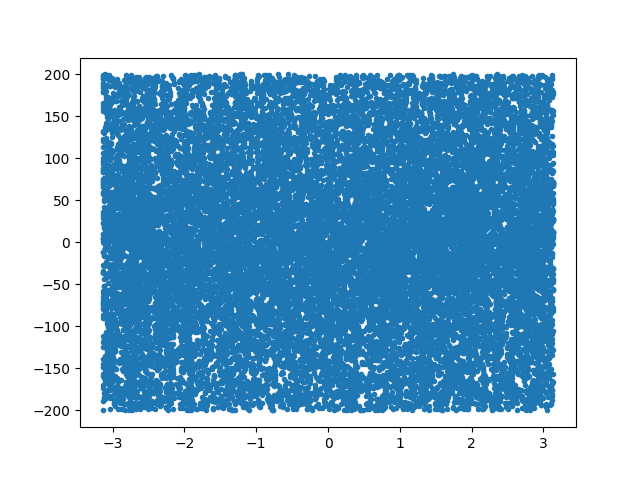

In [20]:
def flatimg(truth):
    data = truth[truth.particle_id != 0]
    data = data[data.tz.abs() < 200]
    display(data.describe())
    plt.figure()
    pd.Series(data.tz.values, sp.angle(data.tx + 1j*data.ty)).plot(style=".")
flatimg(truth)

List of particles with 12 nhits

In [24]:
particles[particles.nhits == 12]

,particle_id,vx,vy,vz,px,py,pz,q,nhits
3,4503874505277440,-0.009288,0.009861,-0.077879,0.257539,-0.676718,0.991616,1,12
5,4504011944230912,-0.009288,0.009861,-0.077879,0.795277,-1.685200,-3.520890,1,12
8,4504424261091328,-0.009288,0.009861,-0.077879,-1.652120,0.453142,-0.533958,-1,12
11,4504630419521536,-0.009288,0.009861,-0.077879,-0.657957,0.258518,-5.331950,1,12
13,4504767858475008,-0.009288,0.009861,-0.077879,-0.230791,0.827567,-5.754810,-1,12
19,4505523772719104,-0.009288,0.009861,-0.077879,0.104399,0.321294,-0.946753,1,12
26,4506073528532992,-0.009288,0.009861,-0.077879,0.074959,0.258644,-0.196200,1,12
36,4507035601207296,-0.009288,0.009861,-0.077879,0.605914,-0.209601,3.348040,-1,12
41,4507447918067712,-0.009288,0.009861,-0.077879,-0.741775,4.363660,-0.921999,1,12
44,4507654076497920,-0.009288,0.009861,-0.077879,-0.034785,0.978504,-0.135103,-1,12


Function to plot particle with specific id

<IPython.core.display.Javascript object>


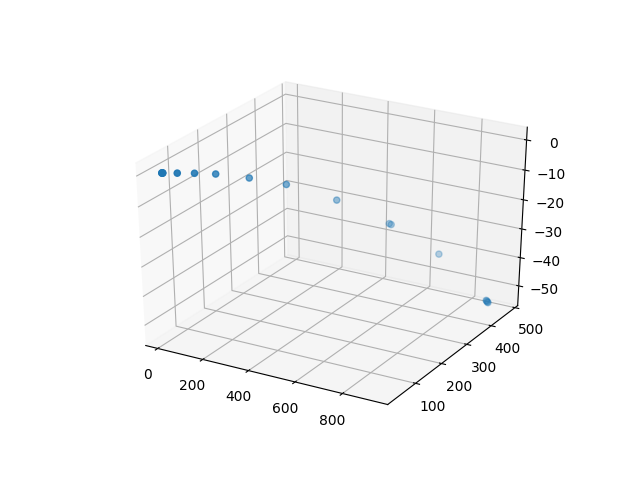

In [169]:
def plotTrack(pid):
    data = truth[truth.particle_id == pid]
    plt.figure()
    ax = plt.axes(projection="3d")
    ax.scatter(xs=data.tx, ys=data.ty, zs=data.tz)
plotTrack(153125617146003456)

### Number of particles per nhit

<IPython.core.display.Javascript object>


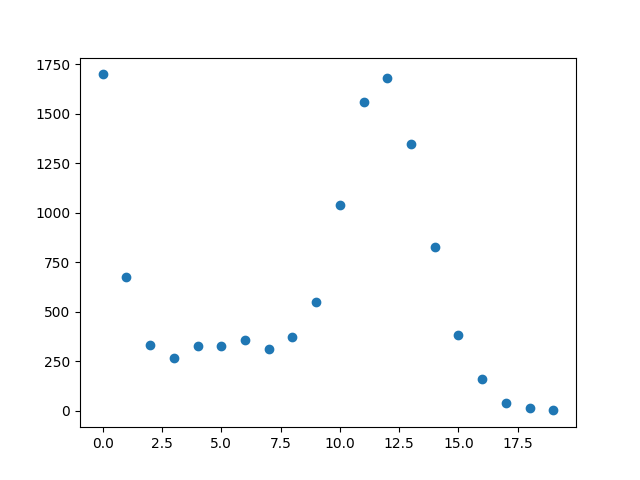

In [118]:
plt.figure()
def nhits():
    data = particles.groupby("nhits")["particle_id"].count()
    plt.scatter(data.index.values, data.values)
nhits()

### Script adopted from `cylinder_fit` package modified to vary height of cylinder on the plot

In [56]:
def show_fit(w_fit, C_fit, r_fit, Xs, height=20):
    '''Plot the fitting given the fitted axis direction, the fitted
    center, the fitted radius and the data points.
    '''

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    # Plot the data points
    
    ax.scatter([X[0] for X in Xs], [X[1] for X in Xs], [X[2] for X in Xs])
   
    # Get the transformation matrix

    theta = np.arccos(np.dot(w_fit, np.array([0, 0, 1])))
    phi = np.arctan2(w_fit[1], w_fit[0])

    M = np.dot(rotation_matrix_from_axis_and_angle(np.array([0, 0, 1]), phi),
               rotation_matrix_from_axis_and_angle(np.array([0, 1, 0]), theta))

    # Plot the cylinder surface
   
    delta = np.linspace(-np.pi, np.pi, 20)
    z = np.linspace(-height, height, 20)

    Delta, Z = np.meshgrid(delta, z)
    X = r_fit * np.cos(Delta)
    Y = r_fit * np.sin(Delta)

    for i in range(len(X)):
        for j in range(len(X[i])):
            p = np.dot(M, np.array([X[i][j], Y[i][j], Z[i][j]])) + C_fit

            X[i][j] = p[0]
            Y[i][j] = p[1]
            Z[i][j] = p[2]

    ax.plot_surface(X, Y, Z, alpha=0.2)

    # Plot the center and direction

    ax.quiver(C_fit[0], C_fit[1], C_fit[2], 
            r_fit * w_fit[0], r_fit * w_fit[1], r_fit * w_fit[2], color='red')


    plt.show()

### Returns list of errors per nhit (limited to 50 points)

Error being measured in effective distances between hits

In [99]:
def errorlist_for_nhit(nhit):
    errors = []
    
    try:
        sam = particles[particles.nhits == nhit].sample(50).particle_id
    except ValueError:
        sam = particles[particles.nhits == nhit].particle_id
    
    for pid in sam:
        data = truth[truth.particle_id == pid].loc[:, ["tx", "ty", "tz"]].values
        w, C, r, err = cylinder_fitting.fit(data)
        scale = sp.sum((data.min(axis=0)-data.max(axis=0))**2)**(1/2)/len(data)
        errors.append(err/scale)
    return sp.array(errors)

An example of analysis for nhits = 16

In [77]:
res = errorlist_for_nhit(16)

In [78]:
res.mean(), res.std(), sorted(res)[(len(res)*3)//4]

(1955.0582727450226, 7218.252482458194, 344.5346747266174)

Return quartile of dimensionless error of fitting as function of nhits.

In [101]:
def averr_per_nhit():
    res = dict()
    for nhit in particles.nhits.unique():
        if nhit == 0:
            continue
        try:
            byte = sorted(errorlist_for_nhit(nhit))
        except:
            print("err fitting: {}".format(nhit))
            continue
        byte = byte[(3*len(byte))//5]
        res.update({nhit: byte})
    return res

In [149]:
res = averr_per_nhit()

/home/vindex10/projects/.venvs/trackml/lib/python3.6/site-packages/cylinder_fitting/fitting.py:49: RuntimeWarning: invalid value encountered in true_divide
  v = np.dot(A_hat, sum(np.dot(Y, Y) * Y for Y in Ys)) / np.trace(np.dot(A_hat, A))


err fitting: 1


Magnitude of error of fitting as a function of nhits. Size of the point corresponds to the number of events with specified nhit

<IPython.core.display.Javascript object>


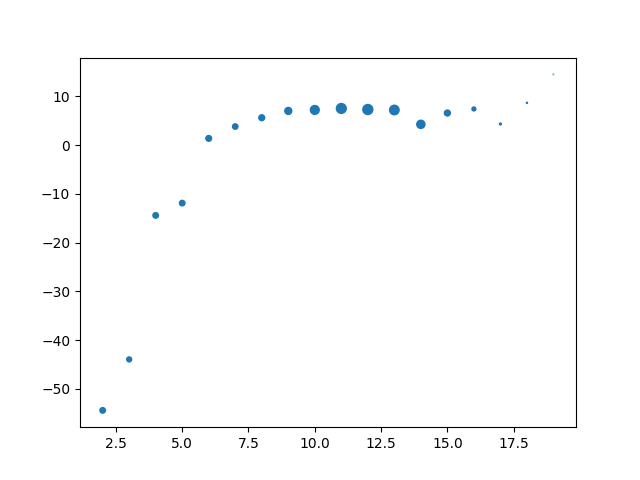

In [151]:
plt.figure()
data = sp.array([(k, v) for k, v in res.items()])
data = data[sp.argsort(data.T[0])]
plt.scatter(data[:, 0], sp.log(data[:, 1]), s=sp.arctan(particles.groupby("nhits")["particle_id"].count()[data[:, 0]]/1000)*50)
plt.savefig("err_of_nhits.png")

### Good cylinder fit

2.332671370244077e-06


<IPython.core.display.Javascript object>


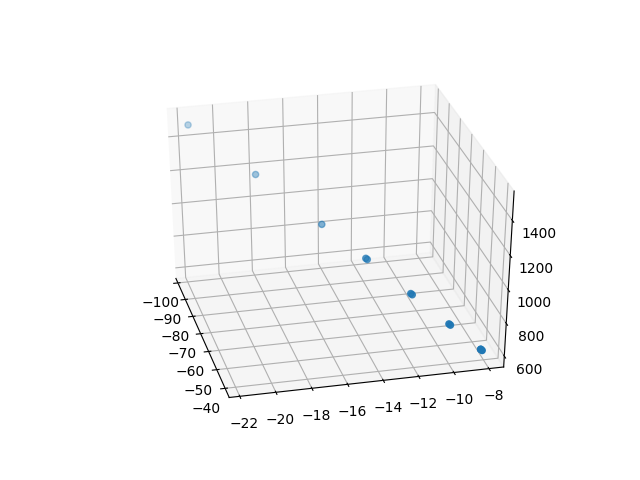

In [154]:
data = truth[truth.particle_id == 4512601878822912].loc[:, ["tx", "ty", "tz"]].values
w, C, r, err = cylinder_fitting.fit(data)
scale = sp.sum((data.min(axis=0)-data.max(axis=0))**2)**(1/2)/len(data)
print(err/scale)
plt.figure()
ax = plt.axes(projection="3d")
ax.scatter(*data.T)

### Bad cylinder fit

16420.971115983444


<IPython.core.display.Javascript object>


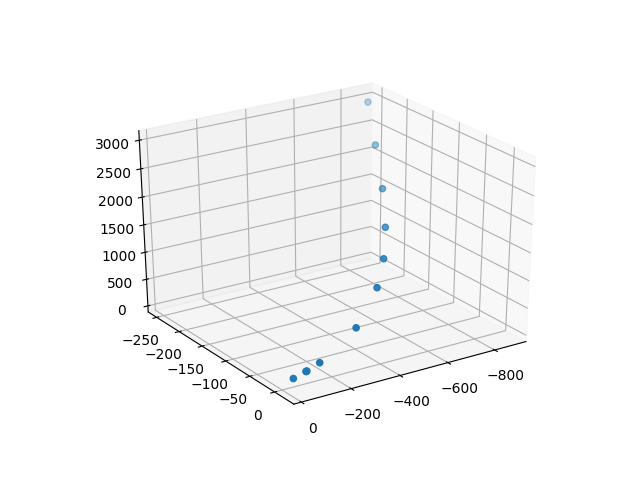

In [156]:
data = truth[truth.particle_id == 968282853416632320].loc[:, ["tx", "ty", "tz"]].values
w, C, r, err = cylinder_fitting.fit(data)
scale = sp.sum((data.min(axis=0)-data.max(axis=0))**2)**(1/2)/len(data)
print(err/scale)
plt.figure()
ax = plt.axes(projection="3d")
ax.scatter(*data.T)

## Fitting with lines

In [157]:
def line(data, a, b, c, d):
    return d/c - data[:, 0]*a/c - data[:, 1]*b/c

<IPython.core.display.Javascript object>


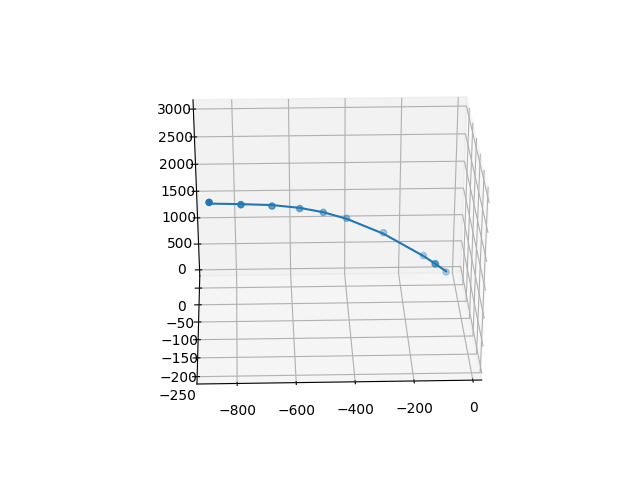

In [175]:
data = truth[truth.particle_id == 968282853416632320].loc[:, ("tx", "ty", "tz")].values
params, _ = sp.optimize.curve_fit(line, data[:, 0:2], data[:, 2])
plt.figure()
ax = plt.axes(projection="3d")
ax.scatter(*data.T)
ax.plot(data[:, 0], data[:, 1], line(data[:, 0:2], *params))